# Introducción
    El siguiente trabajo consta de un estudio de análisis de elasticidad demanda-precio en contexto inflacionario de las ventas de distribuidores del sector consumo masivo en formato B2B, para lograr estimar mediante un modelo de machine learning la demanda que se consiguiera al realizar un aumento de precio en tal contexto.

### Objetivo
    El objetivo de este trabajo es realizar un modelo que pueda estimar la variación de demanda que sufrirá una empresa al subir o bajar precios en un contexto inflacionario.

### Hipótesis sobre el efecto del precio de venta:
    Hipótesis nula: No hay relación entre el precio de venta y el volumen de ventas. Un aumento en el precio de venta no tiene impacto en el volumen de ventas.
    Hipótesis alternativa: Existe una relación inversa entre el precio de venta y el volumen de ventas. Es decir, se espera que un aumento en el precio de venta conduzca a una disminución en el volumen de ventas, y viceversa.
    
##### Medición
    Concluiremos que no existe una relación entre el precio de venta y el volumen de ventas, si el coeficiente del modelo de regresión lineal elegido no supera el valor 0,05.

In [1]:
#Importo librerías
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib import pyplot as plt
sns.set_style('whitegrid')
import warnings

In [2]:
#Función para mostrar valores en formato $
def formato_dolar_simple(valor):
    return f'${valor:.0f}'

#Función para mostrar valores en formato miles
def formato_miles_simple(valor):
    return "{:,.0f}".format(int(valor)).replace(",", "@").replace(".", ",").replace("@", ".")

#Función para mostrar valores en formato $
def formato_dolar_etiqueta(valor, _):
    return f'${valor:.0f}'

#Función para mostrar valores en formato miles
def formato_miles_etiqueta(valor, _):
    return "{:,.0f}".format(int(valor)).replace(",", "@").replace(".", ",").replace("@", ".")

In [3]:
#Parámetros de gráficos
sns.set(style="ticks", font_scale=1, rc={"font.family": "Segoe UI"})

In [4]:
#cargo dataset
url = "https://github.com/Hart-Hunt/Coderhouse---Data-Science/raw/main/Base%20Ventas%20Retail%20v3.xlsx"
dataset_orig = pd.read_excel(url)

In [5]:
df = dataset_orig.copy()
df.replace([np.inf, -np.inf], np.nan, inplace=True)

### Dataset:
    El dataset planteado contiene información de ventas de distribuidores del sector de consumo masivo operando en la región de Gran Buenos Aires.
    Los datos se presentan a nivel de granularidad producto-cliente, agrupados por semana.
###### Anonimización:
    Por cuestiones de confidencialidad, los campos descriptivos de tanto los productos como los clientes fueron anonimizados previo al comienzo de este análisis mediante seudonimización. Campos tales como localidad, partido, canal no fueron alterados del dataset original.

# Exploratory Data Analysis (EDA)

### Limpieza del dataset
    Comenzamos a detallar y analizar el dataset.

In [6]:
#Viendo la cantidad de campos y registros
df.shape

(102457, 15)

    El dataset contiene una gran cantidad de registros y campos. Veamos los campos con una pequeña muestra.

In [7]:
df.sample(5)

,Semana,Semana (Lunes),Tiene Feriado,Producto,Marca,Tipo Packaging,KG / U,U / Pack,Cliente,Canal,Localidad,Partido,KG,Precio Neto,Precio Neto Deflactado
19606,Semana 08 de 2023,2023-02-13,NO,Munchie x4,Munchie,Tipo 1,0.080,4,Cliente 7327544,Autoservicio,General Rodríguez,General Rodríguez,15.360000,1654.023388,1494.904993
14338,Semana 05 de 2024,2024-01-29,NO,Flavori x4,Flavori,Tipo 1,0.069,4,Cliente 9187203,Autoservicio,González Catán,La Matanza,19.872000,4080.273211,997.239589
65560,Semana 32 de 2023,2023-07-31,NO,Flavori x4,Flavori,Tipo 1,0.069,4,Cliente 2798518,Kiosco,Isidro Casanova,La Matanza,2.208000,2001.634812,1177.882128
71886,Semana 36 de 2023,2023-08-28,NO,Munchie x4,Munchie,Tipo 1,0.080,4,Cliente 8452744,Otros,Virrey Del Pino,La Matanza,-1.920000,2796.933464,1495.225349
79531,Semana 41 de 2023,2023-10-02,NO,Munchie x4,Munchie,Tipo 1,0.080,4,Cliente 4414731,Almacén,Paso Del Rey,Moreno,15.840495,2421.192015,1166.796720


###### Se detallan los campos:
    
    Semana, Semana (Lunes): Semana correspondiente al registro.
    Tiene Feriado: Campo con valor SI para las semanas que tuvieron como mínimo un feriado nacional.

    Producto: Descripción del producto (anonimizado).
    Marca: Marca del producto (anonimizado).
    Tipo Packaging: Tipo de packaging del producto.
    KG / U: Peso en KG por unidad de producto dentro del pack.
    U / Pack: Unidades de producto por cada pack.
    
    Cliente: Nombre del cliente (llamado por su número de cliente).
    Localidad: Donde reside el ciente.
    Partido: Agrupador de Localidad.
    Canal: Tipo de cliente según clasificación tipo en sector consumo masivo.
    
    KG: Venta en cantidades medida en KGs.
    Precio: Precio de venta neto sin IVA, medido en pesos argentinos / KG.
    Precio Deflactado: Campo Precio, dividido por valor del Índice de Precios de Consumidor General Nacional [Fuente: INDEC], intrapolado semanalmente (mismo % de variación en cada semana por mes).

    El dataset por lo tanto tiene las ventas realizadas por empresas distribuidoras en formato B2B (Business To Business), de productos del sector consumo masivo.
    La venta se encuentra cerrada por semana, y al ser de Argentina del año 2023 se deberían observar comportamientos inflacionarios de precio.

    Para esto sin embargo debemos avanzar en la limpieza del dataset, para un correcto estudio del mismo.

In [8]:
# Chequeamos registros nulos

columnas_con_nulos = df.columns[df.isnull().any()]

# Mostrar las columnas con valores nulos
print("Columnas con valores nulos:")
print(columnas_con_nulos)

Columnas con valores nulos:
Index(['Precio Neto', 'Precio Neto Deflactado'], dtype='object')


    El dataset como se observa, contiene solamente registros nulos en las variables Precio Neto y Precio Neto Deflactado.

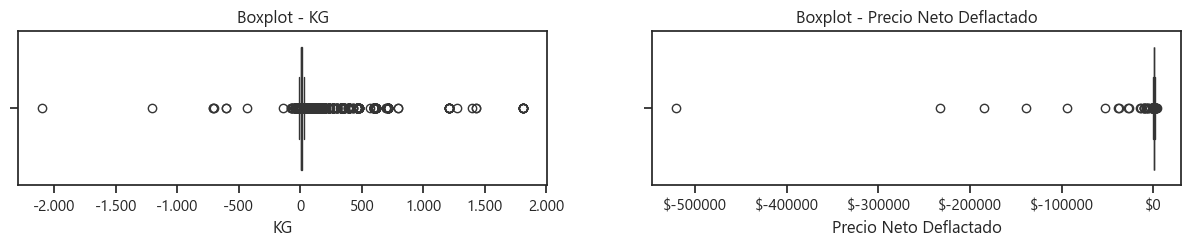

In [9]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")# Crear una figura y ejes compartidos
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(15, 2))

    # Boxplot para Campo1
    sns.boxplot(x=df['KG'], ax=axs[0], palette = 'viridis')
    axs[0].set_title('Boxplot - KG')
    axs[0].xaxis.set_major_formatter(FuncFormatter(formato_miles_etiqueta))

    # Boxplot para Campo2
    sns.boxplot(x=df['Precio Neto Deflactado'], ax=axs[1], palette = 'viridis')
    axs[1].set_title('Boxplot - Precio Neto Deflactado')
    axs[1].xaxis.set_major_formatter(FuncFormatter(formato_dolar_etiqueta))

    # Mostrar la figura
    plt.show()


In [10]:
print(" Cantidad de registros con Precio Neto <= 1: ",df[df['Precio Neto']<=1]['Precio Neto'].size, "\n",
      "Cantidad de registros con KG <= 0: ",df[df['KG']<=0]['KG'].size, "\n",
      "Cantidad de registros con (KG <= 0, o Precio Neto <= 1): ",df[(df['KG'] <= 0) | (df['Precio Neto'] <= 1)]['KG'].size, "\n",
      "Porcentaje de registros a quitar sobre total: {:.1f}%".format(100*df[(df['KG'] <= 0) | (df['Precio Neto'] <= 1)]['KG'].size / df.KG.size)
     )

 Cantidad de registros con Precio Neto <= 1:  51 
 Cantidad de registros con KG <= 0:  3345 
 Cantidad de registros con (KG <= 0, o Precio Neto <= 1):  3381 
 Porcentaje de registros a quitar sobre total: 3.3%


    Por otro lado sí se observan valores negativos y 0, tanto en KG como en Precio.

    Se nos informó que el dataset podía contener tales casos, los cuales de ocurrir son errores de medición de la muestra. 
    Dentro de los mismos, tenemos los siguientes casos:
        KG < 0 & Precio Neto = 0: Error en la variable, no hubo venta.
        KG < 0 & Precio Neto < 0: Error en la variable, Importe Neto devuelto sin venta involucrada.
        KG < 0 & 0 < Precio Neto < 1: Error en la variable, importes varios devueltos al cliente.
        KG < 0 & Precio Neto > 0: Devolución del producto, se registra como KG vendidos negativos con Precio Neto positivo.
        
    Nuestro objetivo es medir la variabilidad de volumen al modificar el precio, lo cual no es posible matemáticamente calcular con datos con Precio Neto <= 0. Tomamos como assumption una muestra de los datos que no considera los valores de KG < 0, o Precio < 1. Los registros quitados del estudio representan el 3,3% del total de la muestra.

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Quitamos valores negativos o 0 en KG o en Precio
    df2 = df[(df['KG'] > 0) & (df['Precio Neto'] > 1)]

    # Convertir valores infinitos en NaN después de filtrar el DataFrame
    df2.replace([np.inf, -np.inf], np.nan, inplace=True)

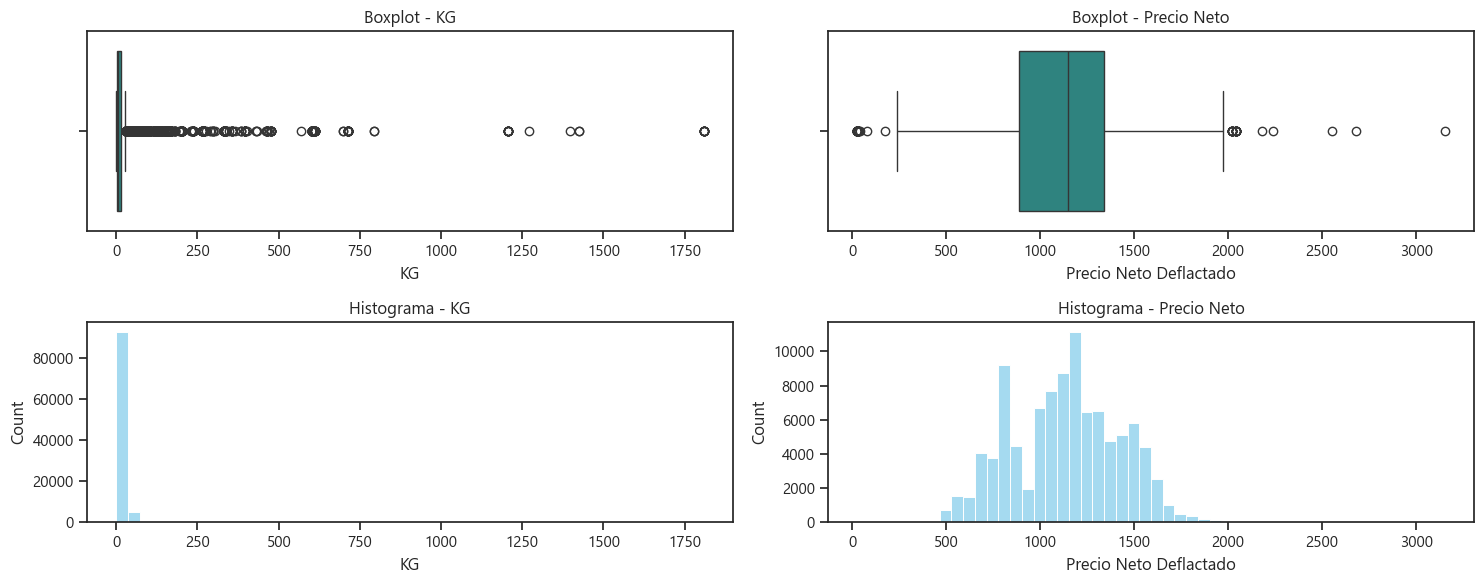

In [12]:
# Supongamos que ya tienes tu DataFrame df

# Quitamos valores negativos o 0 en KG o en Precio
df2 = df[(df['KG'] > 0) & (df['Precio Neto'] > 1)].copy()  # Hacer una copia explícita del DataFrame

# Convertir valores infinitos en NaN después de filtrar el DataFrame
df2.replace([np.inf, -np.inf], np.nan, inplace=True)

# Desactivar las advertencias temporariamente
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Crear una figura y ejes compartidos
    fig, axs = plt.subplots(2, 2, figsize=(15, 6))

    # Boxplot para Campo1
    sns.boxplot(x=df2['KG'], ax=axs[0, 0], palette='viridis')
    axs[0, 0].set_title('Boxplot - KG')

    # Boxplot para Campo2
    sns.boxplot(x=df2['Precio Neto Deflactado'], ax=axs[0, 1], palette='viridis')
    axs[0, 1].set_title('Boxplot - Precio Neto')

    # Histograma para Campo1
    sns.histplot(x=df2['KG'], ax=axs[1, 0], color='skyblue', bins=50)
    axs[1, 0].set_title('Histograma - KG')

    # Histograma para Campo2
    sns.histplot(x=df2['Precio Neto Deflactado'], ax=axs[1, 1], color='skyblue', bins=50)
    axs[1, 1].set_title('Histograma - Precio Neto')

    # Ajustar el espacio entre los subplots
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

    Desde el lado de la variable Precio, se lograron eliminar outliers mediante el último método. Sin embargo, el boxplot arriba muestra que se siguen observando otros outliers que deberán ser analizados mediante otras técnicas.
    La variable KG por otro lado, si bien también mejoró, presenta una alta cantidad de outliers, lo cual requiere de un mayor análisis.
     Ambas variables, KG y Precio Neto, deberían de comportarse de manera distinta dependiendo :
         1. El Canal de ventas al cual se realizó la venta. Por ejemplo, canales como Kioscos deberían de mostrar valores distintos a Mayoristas.
         2. Para el caso del Precio Neto, debería de comportarse distinto según la semana que se realizó la venta. Más aún, el Precio Neto deflactado debería de no mostrar la misma tendencia.

    Graficamos un histograma de variable KG por Canal para analizar el primer punto:

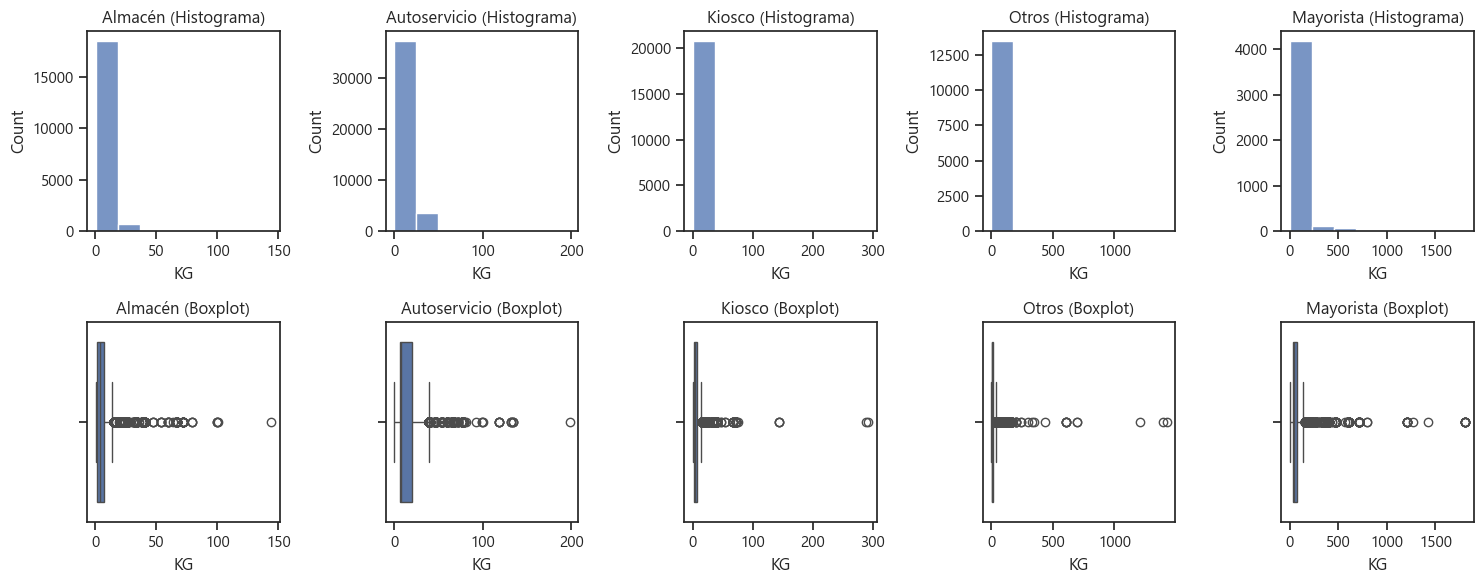

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Crear una figura y ejes con 2 filas y 5 columnas
    fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=False)

    # Aplanar el arreglo de ejes para facilitar el bucle
    axs = axs.flatten()

    # Generar histogramas por canal
    for i, canal in enumerate(df2['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df2[df2['Canal'] == canal]

        # Generar histograma para el canal actual
        sns.histplot(data=datos_canal, x="KG", ax=axs[i], bins=8)  # Ajusta bins según tus necesidades
        axs[i].set_title(f'{canal} (Histograma)')

    # Generar 5 boxplots adicionales
    for i, canal in enumerate(df2['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df2[df2['Canal'] == canal]

        # Generar boxplot para el canal actual
        sns.boxplot(data=datos_canal, x="KG", ax=axs[i + 5])
        axs[i + 5].set_title(f'{canal} (Boxplot)')    

    # Ajustar el espacio entre los gráficos
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

    El histograma muestra que existe una distribución asimétrica a la derecha, con una cola derecha más larga.
    Los histogramas más los boxplot nos muestran que el Canal es un buen segregador de los datos, para identificar los outliers del campo KG.
    Hacemos el mismo ejercicio con las variables Precio Neto y Precio Neto Deflactado.

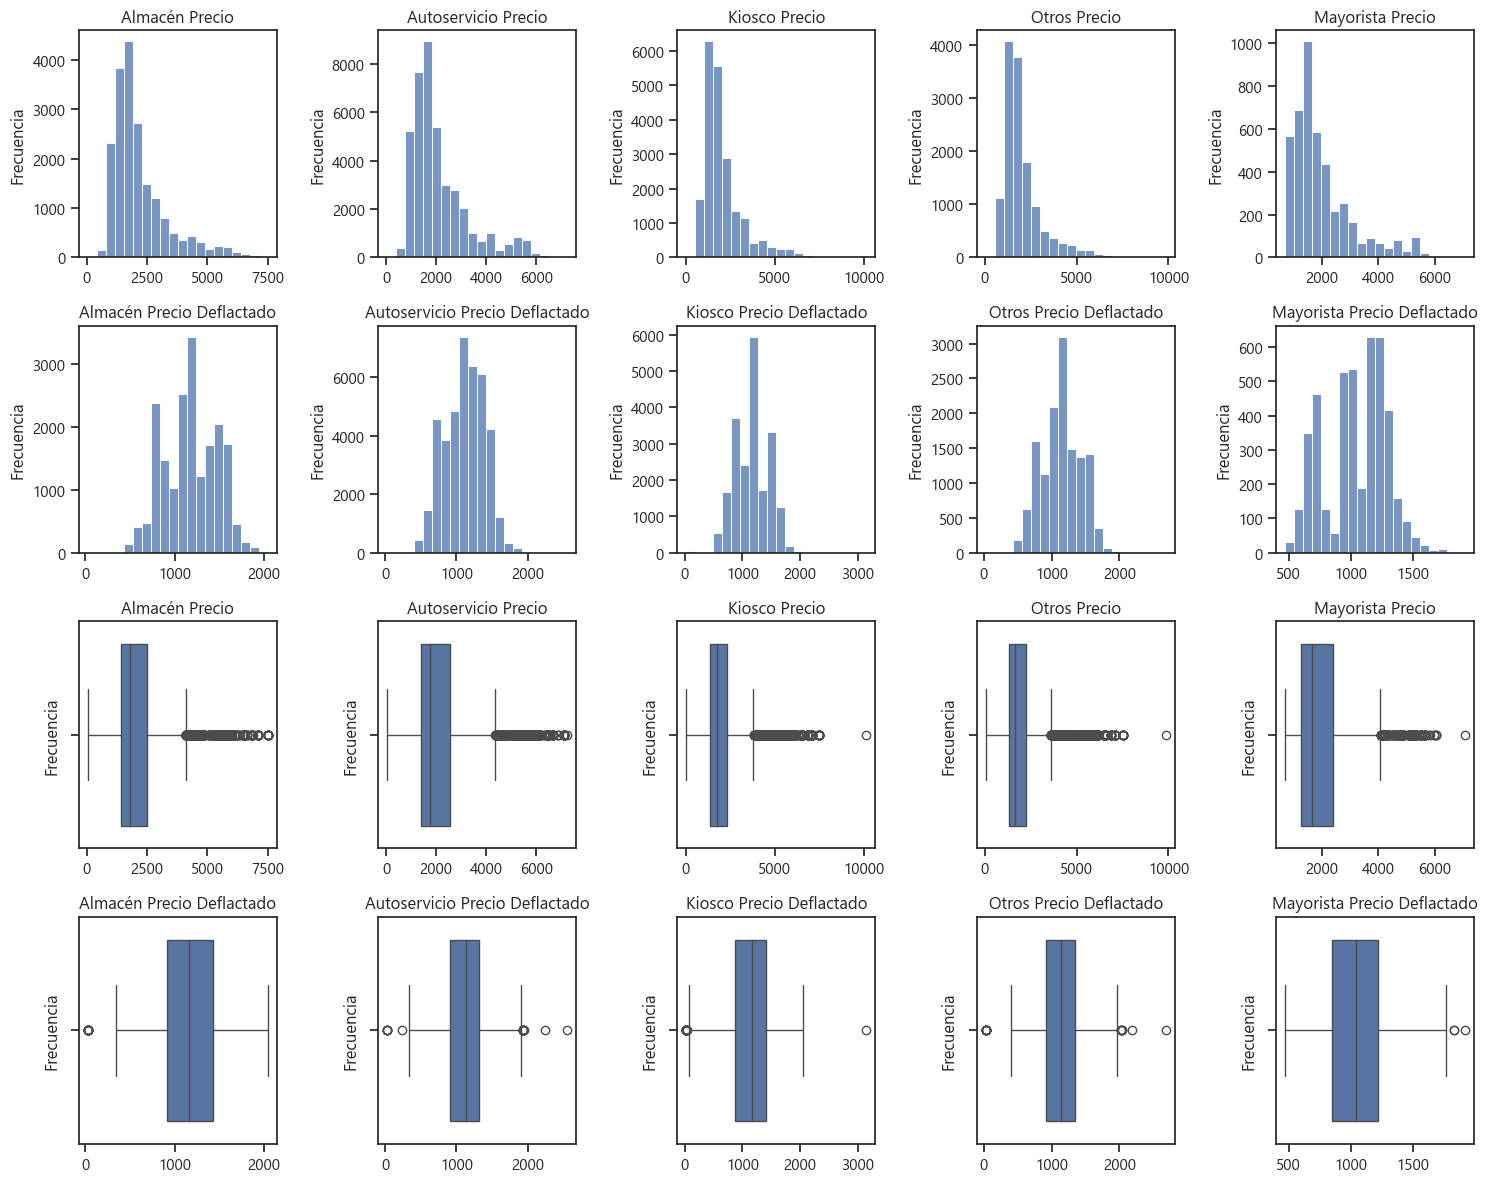

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Crear una figura y ejes con 4 filas y 5 columnas
    fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharey=False)

    # Aplanar el arreglo de ejes para facilitar el bucle
    axs = axs.flatten()

    # Generar histogramas de Precio Neto y Precio Neto Deflactado por canal
    for i, canal in enumerate(df2['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df2[df2['Canal'] == canal]

        # Generar histograma para Precio Neto
        sns.histplot(data=datos_canal, x="Precio Neto", ax=axs[i], bins=20)  # Ajusta bins según tus necesidades
        axs[i].set_title(f'{canal} Precio')
        axs[i].set_xlabel('')  # Eliminar nombre del eje x
        axs[i].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

        # Generar histograma para Precio Neto Deflactado
        sns.histplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 5], bins=20)  # Ajusta bins según tus necesidades
        axs[i + 5].set_title(f'{canal} Precio Deflactado')
        axs[i + 5].set_xlabel('')  # Eliminar nombre del eje x
        axs[i + 5].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

    # Generar 5 boxplots adicionales de Precio Neto y Precio Neto Deflactado por canal
    for i, canal in enumerate(df2['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df2[df2['Canal'] == canal]

        # Generar boxplot para Precio Neto
        sns.boxplot(data=datos_canal, x="Precio Neto", ax=axs[i + 10])
        axs[i + 10].set_title(f'{canal} Precio')
        axs[i + 10].set_xlabel('')  # Eliminar nombre del eje x
        axs[i + 10].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

        # Generar boxplot para Precio Neto Deflactado
        sns.boxplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 15])
        axs[i + 15].set_title(f'{canal} Precio Deflactado')
        axs[i + 15].set_xlabel('')  # Eliminar nombre del eje x
        axs[i + 15].set_ylabel('Frecuencia')  # Cambiar nombre del eje y

    # Ajustar el espacio entre los gráficos
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

    Estos gráficos en principio muestra que la variable deflactada tiene una distribución menos sesgada hacia la derecha, y con menor cantidad de outliers. Para el siguiente trabajo, tomaremos la assumption que el Precio Neto ha sido deflactado de manera correcta.

    Antes de tratar con los outliers, realizamos por último un scatterplot de KG y Precio Neto Deflactado (De ahora en más llamado Precio), diferenciado por Canal.

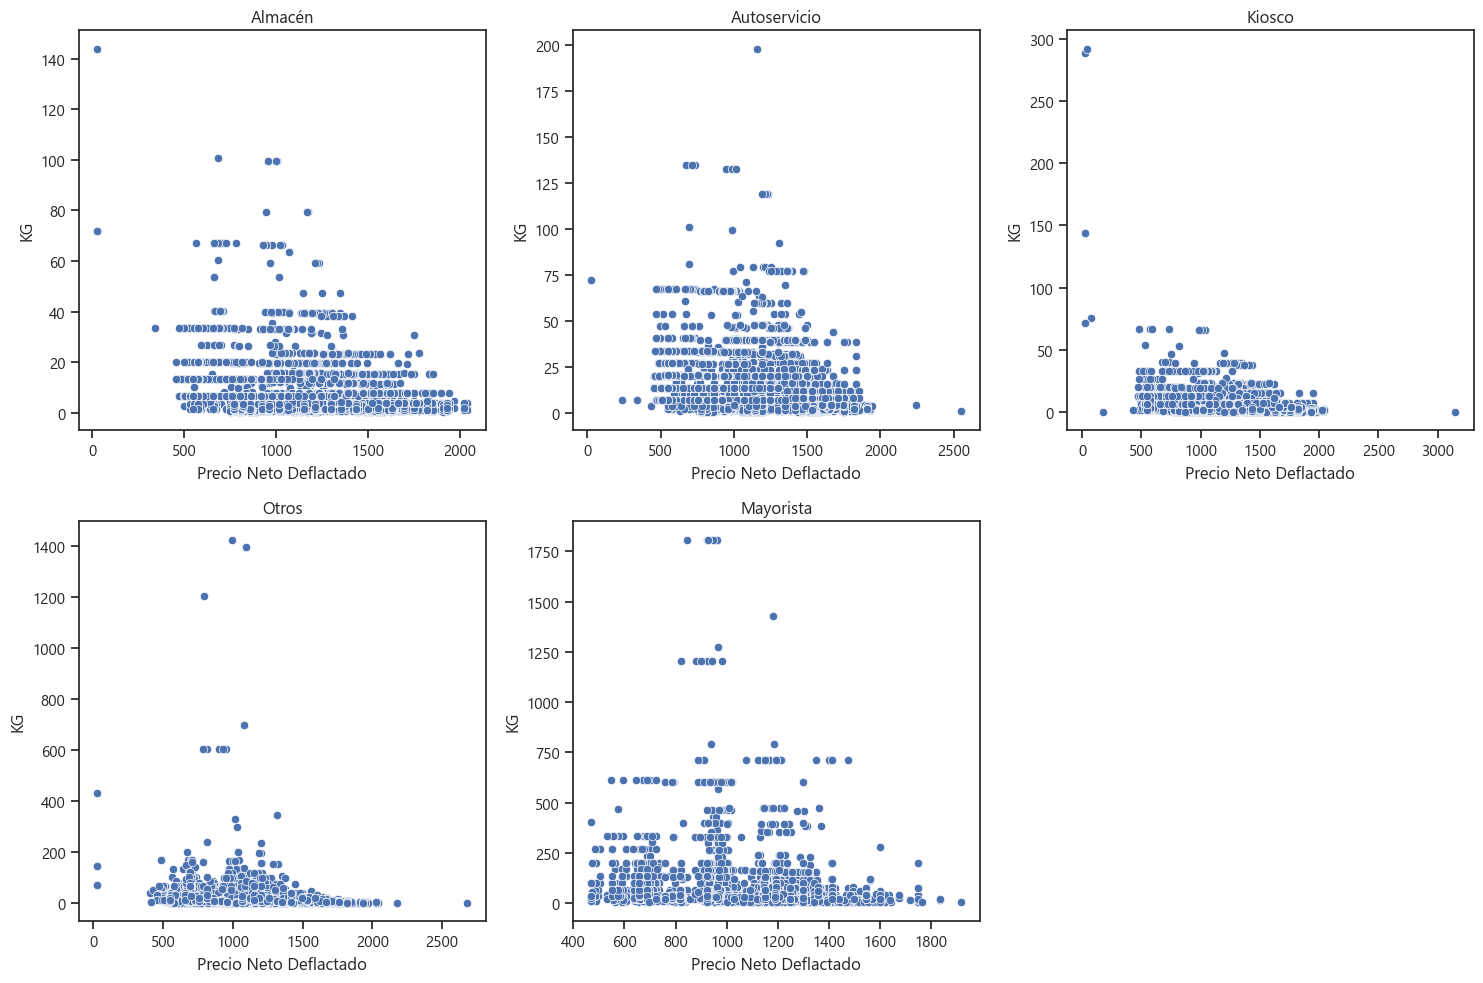

In [15]:
# Filtrar los canales que tienen datos
canales_con_datos = df2['Canal'].unique()

# Calcular el número total de subplots que se necesitarán
num_subplots = len(canales_con_datos)

# Calcular el número de filas y columnas
num_filas = (num_subplots - 1) // 3 + 1
num_columnas = min(num_subplots, 3)

# Crear una figura y ejes con el número correcto de filas y columnas
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(15, num_filas * 5))

# Aplanar el arreglo de ejes para facilitar el bucle
axs = axs.flatten()

# Generar scatterplots por canal
for i, canal in enumerate(canales_con_datos):
    # Filtrar el DataFrame por canal
    datos_canal = df2[df2['Canal'] == canal]
    
    # Generar scatterplot para el canal actual
    sns.scatterplot(data=datos_canal, x="Precio Neto Deflactado", y="KG", ax=axs[i])
    axs[i].set_title(f'{canal}')
    axs[i].set_xlabel('Precio Neto Deflactado')
    axs[i].set_ylabel('KG')

# Ocultar el último subplot si no hay suficientes datos
if num_subplots < num_filas * num_columnas:
    fig.delaxes(axs[num_subplots])

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la figura
plt.show()

    En principio, se observa una correlación negativa entre ambas variables, lo cual responde al concepto de elasticidad demanda-precio. Sin embargo, la presencia de outliers nos dificulta el análisis.
    Trataremos estos outliers mediante el método intercuartil, discriminado por Canal, en las variables KG y Precio.

In [16]:
# Definir el número de iteraciones
num_iteraciones = 5

# Definir la columna
col = 'KG'

# Definir parámetro IQR
par_IQR = 1.5

# Crear una copia de los datos originales
df3 = df2.copy()

# Iterar X veces para eliminar outliers
for _ in range(num_iteraciones):
    # Iterar sobre los valores únicos del campo 'Canal'
    for canal in df3['Canal'].unique():
        # Filtrar los datos para el canal actual
        datos_canal = df3[df3['Canal'] == canal]

        # Calcular el primer y tercer cuartil para la columna 'KG'
        Q1 = datos_canal[col].quantile(0.25)
        Q3 = datos_canal[col].quantile(0.75)

        # Calcular el rango intercuartílico (IQR)
        IQR = Q3 - Q1

        # Definir los límites superior e inferior
        lower_bound = Q1 - par_IQR * IQR
        upper_bound = Q3 + par_IQR * IQR

        # Eliminar los valores fuera del rango para el canal actual
        datos_canal = datos_canal[(datos_canal[col] < lower_bound) | (datos_canal[col] > upper_bound)]

        # Actualizar los datos en df3 eliminando los registros fuera del rango
        df3 = df3.drop(datos_canal.index)

# Reiniciar los índices del DataFrame resultante
df3.reset_index(drop=True, inplace=True)

print("Registros eliminados en esta iteración: ", df2.KG.size - df3.KG.size)
print("Porcentaje de registros eliminados: {:.1f}%".format(100*(df2.KG.size - df3.KG.size)/df3.KG.size))
print("Porcentaje de registros eliminados total: {:.1f}%".format(100*(df.KG.size - df3.KG.size)/df.KG.size))
print("Registros dataset original: ", df.KG.size)
print("Registros con outliers en total: ", df2.KG.size)
print("Registros sin outliers en total: ", df3.KG.size)

Registros eliminados en esta iteración:  7190
Porcentaje de registros eliminados: 7.8%
Porcentaje de registros eliminados total: 10.3%
Registros dataset original:  102457
Registros con outliers en total:  99076
Registros sin outliers en total:  91886


    La iteración corrida filtra los valores por la variable Canal, y elimina los valores de KG fuera del rango intercuartílico.
    Asumimos en este caso que la muestra resultante será representativa de la población. El algoritmo luego lo corremos varias veces para que vaya capturando la mayor cantidad de outliers.
    Como se observa arriba, la cantidad de registros que eliminó es de 7190.
    Corremos el mismo algoritmo para la variable Precio.

In [17]:
# Definir el número de iteraciones
num_iteraciones = 5

# Definir la columna
col = 'Precio Neto Deflactado'

# Definir parámetro IQR
par_IQR = 1.5

# Crear una copia de los datos originales
df4 = df3.copy()

# Iterar X veces para eliminar outliers
for _ in range(num_iteraciones):
    # Iterar sobre los valores únicos del campo 'Canal'
    for canal in df4['Canal'].unique():
        # Filtrar los datos para el canal actual
        datos_canal = df4[df4['Canal'] == canal]

        # Calcular el primer y tercer cuartil para la columna 'KG'
        Q1 = datos_canal[col].quantile(0.25)
        Q3 = datos_canal[col].quantile(0.75)

        # Calcular el rango intercuartílico (IQR)
        IQR = Q3 - Q1

        # Definir los límites superior e inferior
        lower_bound = Q1 - par_IQR * IQR
        upper_bound = Q3 + par_IQR * IQR

        # Eliminar los valores fuera del rango para el canal actual
        datos_canal = datos_canal[(datos_canal[col] < lower_bound) | (datos_canal[col] > upper_bound)]

        # Actualizar los datos en df3 eliminando los registros fuera del rango
        df4 = df4.drop(datos_canal.index)

# Reiniciar los índices del DataFrame resultante
df3.reset_index(drop=True, inplace=True)

print("Registros eliminados en esta iteración: ", df3.KG.size - df4.KG.size)
print("Porcentaje de registros eliminados: {:.1f}%".format(100*(df3.KG.size - df4.KG.size)/df4.KG.size))
print("Porcentaje de registros eliminados total: {:.1f}%".format(100*(df.KG.size - df4.KG.size)/df.KG.size))
print("Registros dataset original: ", df.KG.size)
print("Registros con outliers en total: ", df2.KG.size)
print("Registros sin outliers en total: ", df4.KG.size)

Registros eliminados en esta iteración:  16
Porcentaje de registros eliminados: 0.0%
Porcentaje de registros eliminados total: 10.3%
Registros dataset original:  102457
Registros con outliers en total:  99076
Registros sin outliers en total:  91870


    Como se observa, el dataset resultante del algoritmo anterior nos dejó con pocos outliers para la variable precio, la cual al correr el mismo algortimo sólo eliminó 16 outliers.
    Actualizamos los gráficos para analizar la distribución resultante.

    Boxplot de los datos cerrados (sin segregación por Canal)

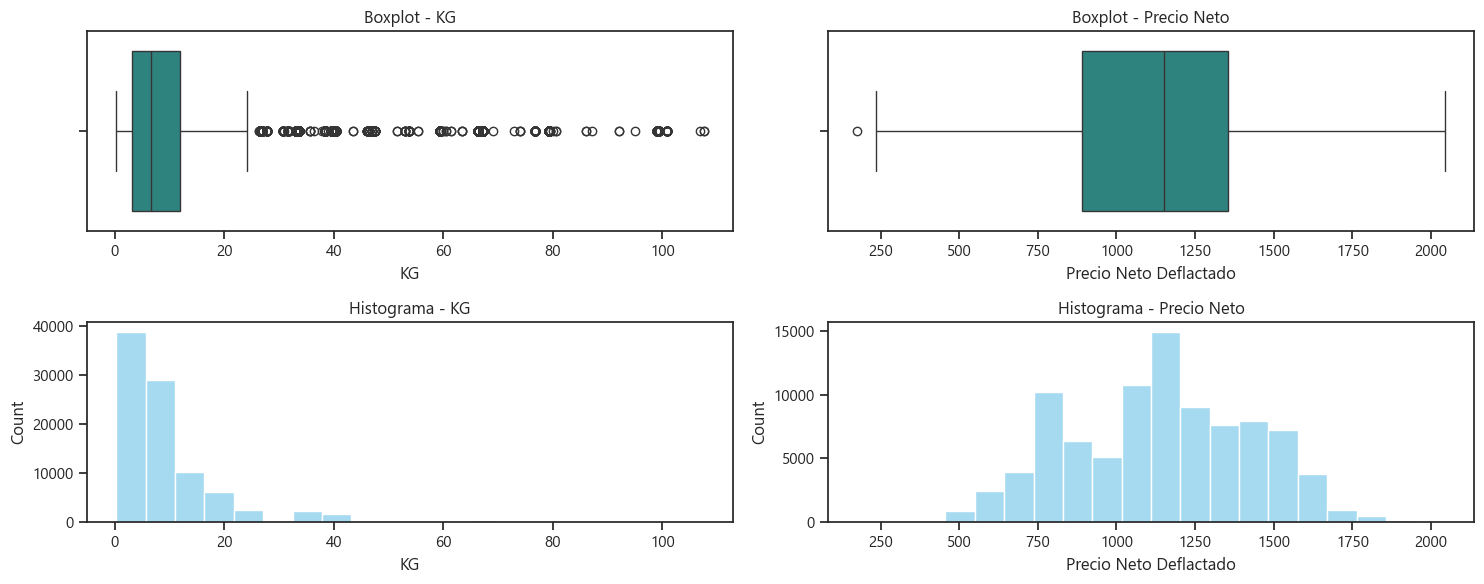

In [18]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Crear una figura y ejes compartidos
    fig, axs = plt.subplots(2, 2, figsize=(15, 6))

    # Boxplot para Campo1
    sns.boxplot(x=df4['KG'], ax=axs[0, 0], palette='viridis')
    axs[0, 0].set_title('Boxplot - KG')

    # Boxplot para Campo2
    sns.boxplot(x=df4['Precio Neto Deflactado'], ax=axs[0, 1], palette='viridis')
    axs[0, 1].set_title('Boxplot - Precio Neto')

    # Histograma para Campo1
    sns.histplot(x=df4['KG'], ax=axs[1, 0], color='skyblue', bins = 20)
    axs[1, 0].set_title('Histograma - KG')

    # Histograma para Campo2
    sns.histplot(x=df4['Precio Neto Deflactado'], ax=axs[1, 1], color='skyblue', bins = 20)
    axs[1, 1].set_title('Histograma - Precio Neto')

    # Ajustar el espacio entre los subplots
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

    Los datos previo a la apertura por Canal muestran una distribución más clara.

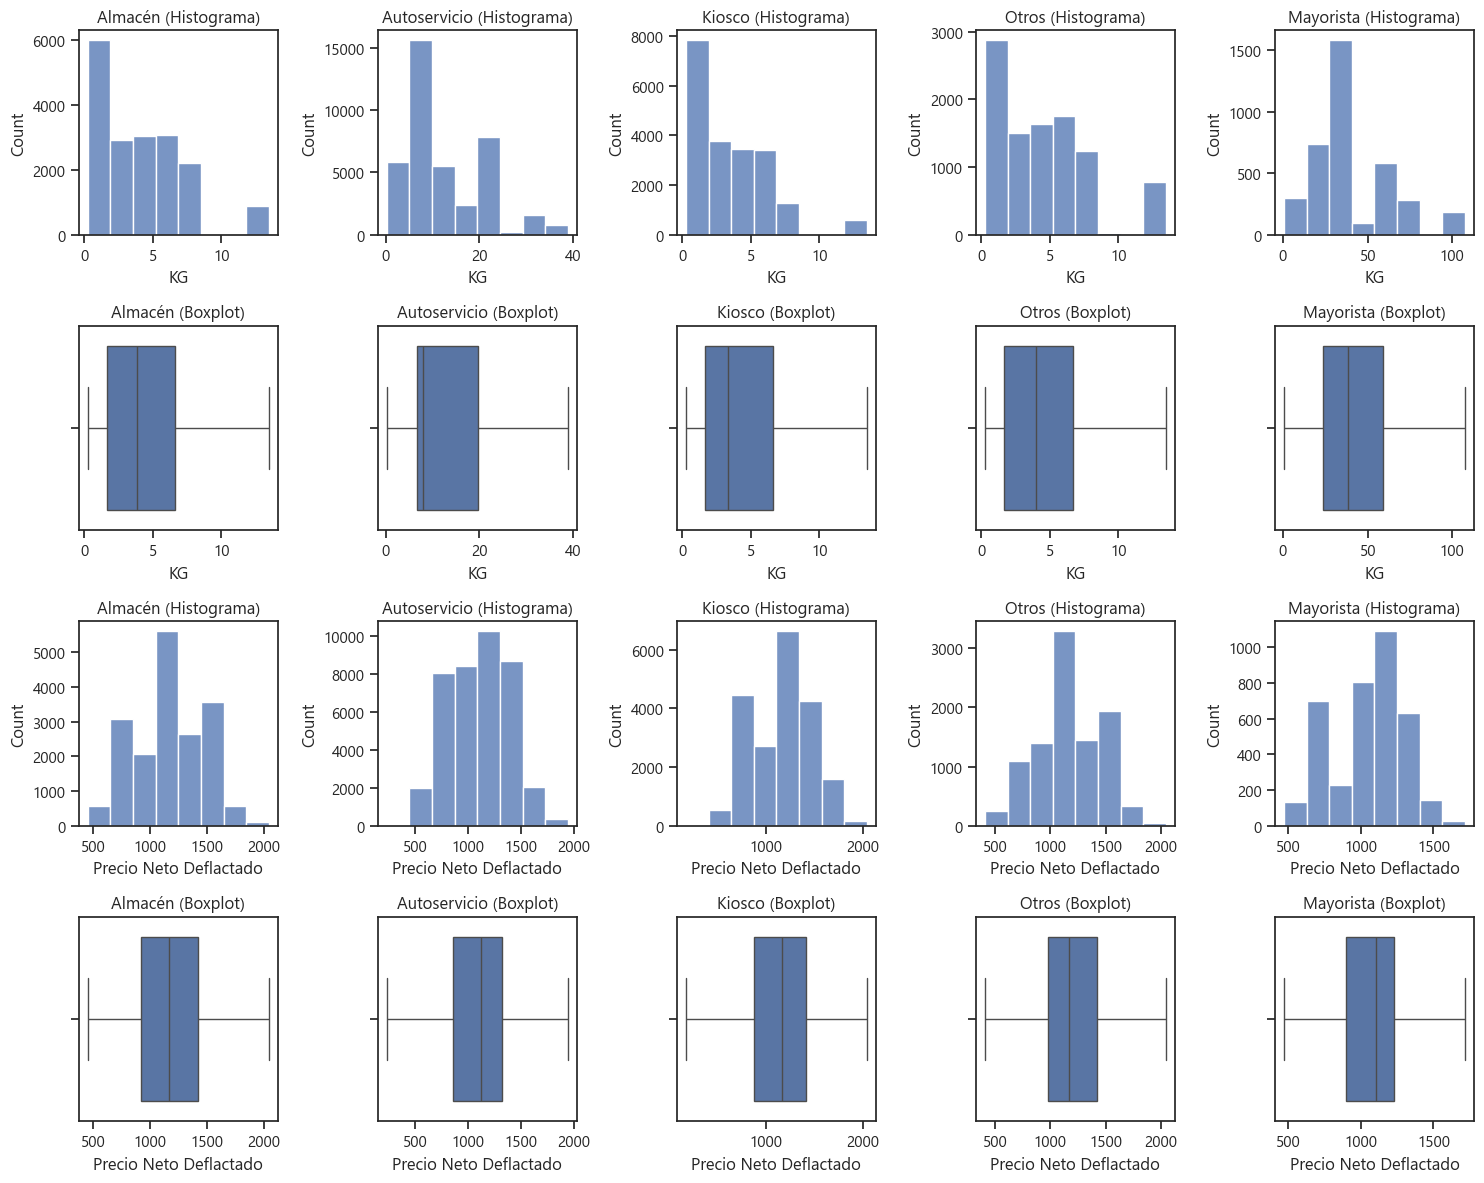

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Crear una figura y ejes con 2 filas y 5 columnas
    fig, axs = plt.subplots(4, 5, figsize=(15, 12), sharey=False)

    # Aplanar el arreglo de ejes para facilitar el bucle
    axs = axs.flatten()

    # Generar histogramas por canal
    for i, canal in enumerate(df2['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df4[df4['Canal'] == canal]

        # Generar histograma para el canal actual
        sns.histplot(data=datos_canal, x="KG", ax=axs[i], bins=8)  # Ajusta bins según tus necesidades
        axs[i].set_title(f'{canal} (Histograma)')

    # Generar 5 boxplots adicionales
    for i, canal in enumerate(df4['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df4[df4['Canal'] == canal]

        # Generar boxplot para el canal actual
        sns.boxplot(data=datos_canal, x="KG", ax=axs[i + 5])
        axs[i + 5].set_title(f'{canal} (Boxplot)')    

    # Generar histogramas por canal
    for i, canal in enumerate(df4['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df4[df4['Canal'] == canal]

        # Generar histograma para el canal actual
        sns.histplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 10], bins=8)  # Ajusta bins según tus necesidades
        axs[i + 10].set_title(f'{canal} (Histograma)')

    # Generar 5 boxplots adicionales
    for i, canal in enumerate(df4['Canal'].unique()):
        # Filtrar el DataFrame por canal
        datos_canal = df4[df4['Canal'] == canal]

        # Generar boxplot para el canal actual
        sns.boxplot(data=datos_canal, x="Precio Neto Deflactado", ax=axs[i + 15])
        axs[i + 15].set_title(f'{canal} (Boxplot)')    

    # Ajustar el espacio entre los gráficos
    plt.tight_layout()

    # Mostrar la figura
    plt.show()

    Vista esta correlación entre Canal y distinto valor esperado de KG y de Precio, veamos un heatmap entre las distintas variables para ver candidatos a variables de control para un modelo predictivo.

### Elección de variables de control


    Para poder elegir entre las distintas variables de control, debemos analizar los distintos valores que cada una presenta.

    Convertimos primero la columna de Semana a una columna ordinal, considerando que la misma posee un orden lógico (cada número de semana es consecuente).
    Por otro lado, quitamos del análisis la columna 'Cliente', que poseerá muchos valores únicos que no suma distinguirlos en el análisis por tratarse de códigos identificadores sin orden predeterminado.

In [20]:
# Creamos una función para convertir la cadena en un número ordinal
def convertir_a_ordinal(semana_texto):
    numero_semana = int(semana_texto.split()[1])  # Extraer el número de semana
    numero_ano = int(semana_texto.split()[3])     # Extraer el número de año
    return numero_ano * 52 + numero_semana       # Convertir a número ordinal

# Aplicar la función a la columna
df5 = df4.copy()
df5['Semana_Ordinal'] = df5['Semana '].apply(convertir_a_ordinal)
df5.drop(['Semana ', 'Semana (Lunes)', 'Cliente'], axis=1, inplace=True)

    Luego, veamos veamos los valores únicos que quedan en cada campo.

In [21]:
# Iterar sobre cada columna e imprimir los valores únicos, excluyendo las columnas 'KG' y 'Precio'
for column in df5.columns:
    if column not in ['KG', 'Precio Neto', 'Precio Neto Deflactado']:
        unique_values = np.sort(df5[column].unique())
        print(f"'{column}': {unique_values}")

'Tiene Feriado': ['NO' 'SI']
'Producto': ['Bistro x4' 'Flavori x4' 'Munchie x4' 'Munchiquito x2']
'Marca': ['Bistro' 'Flavori' 'Munchie']
'Tipo Packaging': ['Tipo 1' 'Tipo 2']
'KG / U': [0.055 0.069 0.08 ]
'U / Pack': [2 4]
'Canal': ['Almacén' 'Autoservicio' 'Kiosco' 'Mayorista' 'Otros']
'Localidad': ['Aldo Bonzi' 'Caseros' 'Castelar' 'Ciudad Evita' 'Cuartel V' 'El Palomar'
 'Francisco Álvarez' 'General Rodríguez' 'González Catán'
 'Gregorio De Laferrere' 'Haedo' 'Isidro Casanova' 'Ituzaingó' 'La Reja'
 'La Tablada' 'Libertad' 'Lomas Del Mirador' 'Marcos Paz' 'Mariano Acosta'
 'Merlo' 'Moreno' 'Morón' 'Parque San Martín' 'Paso Del Rey' 'Pontevedra'
 'Rafael Castillo' 'Ramos Mejía' 'San Antonio de Padua' 'San Justo'
 'San Martín' 'Tapiales' 'Trujui' 'Villa Insuperable' 'Villa Luzuriaga'
 'Villa Madero' 'Virrey Del Pino']
'Partido': ['General Rodríguez' 'General San Martín' 'Ituzaingó' 'La Matanza'
 'Marcos Paz' 'Merlo' 'Moreno' 'Morón' 'Tres de Febrero']
'Semana_Ordinal': [105198 105199

    El campo Localidad tiene varios valores únicos. Estos valores únicos se encuentran agrupados en el campo 'Partido'. Tomaremos como assumption que el agrupador geográfico Partido no quitará representatividad estadística o capacidad explicativa al modelo.
    Se elimina por lo tanto el campo Localidad.
    Hecho esto, se convierten a variables dummy el resto de los campos mediante el método One-Hot Encoding.

In [22]:
# Eliminar la columna 'Localidad' del DataFrame
df5.drop(columns=['Localidad'], inplace=True)

In [23]:
df5['Tiene Feriado'].replace({'NO': 0, 'SI': 1}, inplace=True)

# Obtener todas las columnas categóricas
columnas_categoricas = df5.select_dtypes(include=['object']).columns

# Aplicar one-hot encoding a todas las columnas categóricas
df6 = pd.get_dummies(df5, columns=columnas_categoricas)

print(df6.columns)

Index(['Tiene Feriado', 'KG / U', 'U / Pack', 'KG', 'Precio Neto',
       'Precio Neto Deflactado', 'Semana_Ordinal', 'Producto_Bistro x4',
       'Producto_Flavori x4', 'Producto_Munchie x4', 'Producto_Munchiquito x2',
       'Marca_Bistro', 'Marca_Flavori', 'Marca_Munchie',
       'Tipo Packaging_Tipo 1', 'Tipo Packaging_Tipo 2', 'Canal_Almacén',
       'Canal_Autoservicio', 'Canal_Kiosco', 'Canal_Mayorista', 'Canal_Otros',
       'Partido_General Rodríguez', 'Partido_General San Martín',
       'Partido_Ituzaingó', 'Partido_La Matanza', 'Partido_Marcos Paz',
       'Partido_Merlo', 'Partido_Moreno', 'Partido_Morón',
       'Partido_Tres de Febrero'],
      dtype='object')


    Se pueden observar varias columnas. Quisiéramos ver la matriz de correlación.

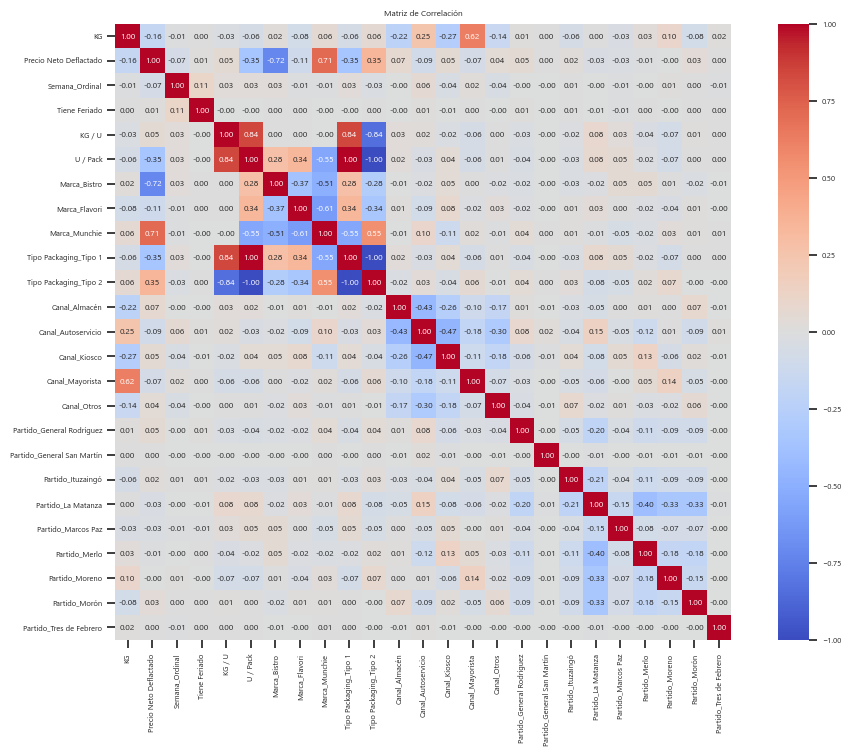

In [24]:
# Seleccionar variables
variables = ['KG', 'Precio Neto Deflactado', 'Semana_Ordinal', 'Tiene Feriado', 'KG / U', 'U / Pack', 
       'Marca_Bistro', 'Marca_Flavori', 'Marca_Munchie',
       'Tipo Packaging_Tipo 1', 'Tipo Packaging_Tipo 2', 'Canal_Almacén',
       'Canal_Autoservicio', 'Canal_Kiosco', 'Canal_Mayorista', 'Canal_Otros',
       'Partido_General Rodríguez', 'Partido_General San Martín',
       'Partido_Ituzaingó', 'Partido_La Matanza', 'Partido_Marcos Paz',
       'Partido_Merlo', 'Partido_Moreno', 'Partido_Morón',
       'Partido_Tres de Febrero']

#Parámetros de gráficos
sns.set(style="ticks", font_scale=0.5, rc={"font.family": "Segoe UI"})

# Calcular la matriz de correlación
correlation_matrix = df6[variables].corr()

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Crear el heatmap de correlación con estilo cuadrado completo
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

# Añadir título
plt.title('Matriz de Correlación')

# Mostrar el heatmap
plt.show()

#Parámetros de gráficos
sns.set(style="ticks", font_scale=1, rc={"font.family": "Segoe UI"})

    Las mayores correlaciones de la variable que queremos explicar, KG, se pueden observar con las variables Precio, y las variables dummy de Canales. El resto de las variables presenta poca correlación, lo cual se deberá considerar al realizar la selección de variables de control del modelo.
    
    Sin embargo, la variable Precio si contiene correlaciones fuertes con variables relacionadas al producto, como las U / Pack, la marca, el tipo de packaging, o el producto en sí (el cual cada uno engloba distintas características). Al haber una correlación entre estas variables, esto también deberá ser considerado en el modelo para minimizar el riesgo de colinealidades entre las mismas.

    Por último, para mostrar esta correlación, graficamos un scatterplot entre KG y Precio por Canal, diferenciando los productos en distintos colores.

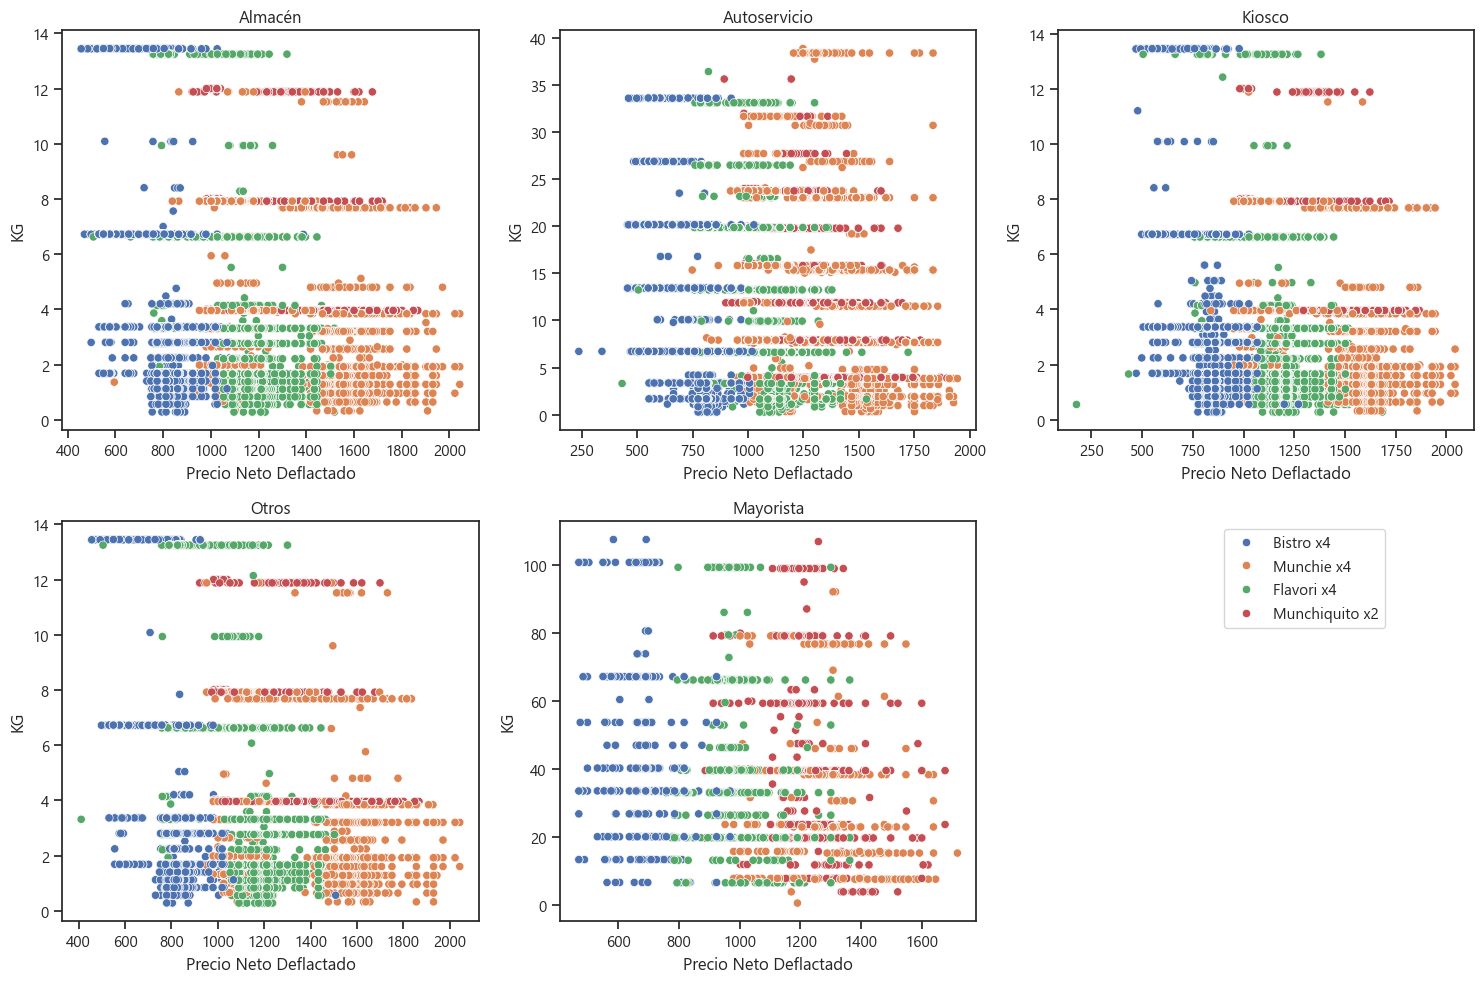

In [25]:
# Filtrar los canales que tienen datos
canales_con_datos = df4['Canal'].unique()

# Calcular el número total de subplots que se necesitarán
num_subplots = len(canales_con_datos)

# Calcular el número de filas y columnas
num_filas = (num_subplots - 1) // 3 + 1
num_columnas = min(num_subplots, 3)

# Crear una figura y ejes con el número correcto de filas y columnas
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(15, num_filas * 5))

# Aplanar el arreglo de ejes para facilitar el bucle
axs = axs.flatten()

# Generar scatterplots por canal
for i, canal in enumerate(canales_con_datos):
    # Filtrar el DataFrame por canal
    datos_canal = df4[df4['Canal'] == canal]
    
    # Generar scatterplot para el canal actual
    sns.scatterplot(data=datos_canal, x="Precio Neto Deflactado", y="KG", ax=axs[i], hue="Producto")
    axs[i].set_title(f'{canal}')
    axs[i].set_xlabel('Precio Neto Deflactado')
    axs[i].set_ylabel('KG')
    
    # Ocultar la leyenda en todos los subplots excepto en el deseado
    if i != 5:  # Índice del subplot de la segunda fila, tercera columna
        axs[i].legend().remove() 
        
    # Mostrar leyenda solo en el subplot deseado
    if i == 5:  # Índice del subplot de la segunda fila, tercera columna
        axs[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Ajustar tamaño de la leyenda
    
# Ocultar el último subplot si no hay suficientes datos
if num_subplots < num_filas * num_columnas:
    fig.delaxes(axs[num_subplots])

# Ajustar el espacio entre los gráficos
plt.tight_layout()

# Mostrar la leyenda fuera de los gráficos
plt.legend(bbox_to_anchor=(2.0, 1.0))

# Mostrar la figura
plt.show()


    Estos gráficos muestran la correlación que hay entre el precio y los canales, y que son fuertes candidatos a ser variables de control de un modelo predictivo de precio y volumen de ventas.

### Armado del modelo

    Para la selección de las variables de control de nuestro modelo de regresión lineal, aplicamos el método de eliminación bidireccional. El mismo combina los métodos de forward selection y backward selection, iterando para agregar variables con p valor menor al parámetro que designamos (en nuestro caso 0,05), y luego eliminando los p valores del modelo resultante que muestran un p valor mayor al parámetro designado (también 0,05 en este estudio).

In [26]:
def stepwise_selection(data, target,SL_in,SL_out):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+[new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.OLS(target, best_features_with_constant).fit().pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features

In [27]:
# Loop sobre todas las columnas del DataFrame
for columna in df6.columns:
    # Verificar si el tipo de dato de la columna es booleano
    if df6[columna].dtype == bool:
        # Convertir los valores booleanos a enteros (True a 1, False a 0)
        df6[columna] = df6[columna].astype(int)


In [28]:
variables1 = ['KG', 'Precio Neto Deflactado', 'Semana_Ordinal', 'Tiene Feriado', 'KG / U', 'U / Pack', 
       'Marca_Bistro', 'Marca_Flavori',
       'Tipo Packaging_Tipo 1', 'Canal_Almacén',
       'Canal_Autoservicio', 'Canal_Kiosco', 'Canal_Mayorista',
       'Partido_General Rodríguez', 'Partido_General San Martín',
       'Partido_Ituzaingó', 'Partido_La Matanza', 'Partido_Marcos Paz',
       'Partido_Merlo', 'Partido_Moreno', 'Partido_Morón',
       'Partido_Tres de Febrero']

In [29]:
df_modelo1 = df6.copy()
df_modelo1.drop('Precio Neto', axis=1, inplace=True)  # Eliminar la columna 'Precio Neto'

X1 = df_modelo1[variables1].loc[:, df_modelo1[variables1].columns != 'KG']      # feature matrix
y1 = df_modelo1['KG']                                  # target feature
X1.head()

,Precio Neto Deflactado,Semana_Ordinal,Tiene Feriado,KG / U,U / Pack,Marca_Bistro,Marca_Flavori,Tipo Packaging_Tipo 1,Canal_Almacén,Canal_Autoservicio,...,Canal_Mayorista,Partido_General Rodríguez,Partido_General San Martín,Partido_Ituzaingó,Partido_La Matanza,Partido_Marcos Paz,Partido_Merlo,Partido_Moreno,Partido_Morón,Partido_Tres de Febrero
0,825.261878,105249,1,0.069,4,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
1,825.261878,105249,1,0.069,4,1,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
2,825.261878,105249,1,0.069,4,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,916.957779,105249,1,0.069,4,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
4,825.261878,105249,1,0.069,4,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0


In [30]:
#Creamos datasets de Entrenamiento y Validación de modelo
X1_train,X1_test,y1_train,y1_test = train_test_split(X1 , y1, test_size=0.3,random_state=42)

In [31]:
# Obtener las características seleccionadas por backward_elimination
features_selected = stepwise_selection(X1_train, y1_train, 0.05, 0.05)

# Obtener las características no seleccionadas
features_not_selected = [col for col in X1.columns if col not in features_selected]

# Mostrar las características no seleccionadas
print("Características seleccionadas:", features_selected)
print()
print("Características no seleccionadas:", features_not_selected)
print()

# Borramos las variables que el método de selección rechazó
X1.drop(features_not_selected, axis=1, inplace=True)
X1_train.drop(features_not_selected, axis=1, inplace=True)
X1_test.drop(features_not_selected, axis=1, inplace=True)

# crear el modelo
lr1 = LinearRegression()
# Ajustar el modelo con X_train y y_train
lr1.fit(X1_train,y1_train)
# Predecir con X_test
y1_pred = lr1.predict(X1_test)

# Obtener los coeficientes del modelo
coeficientes1 = lr1.coef_

# Imprimir los coeficientes
print("Coeficientes del modelo:")
for i, coef in enumerate(coeficientes1):
    print(f" {X1_train.columns[i]}: {coef:.2f}")

# Obtener la constante del modelo
constante1 = lr1.intercept_

# Imprimir la constante
print("Constante del modelo:", constante1)
    
# print("MAE  = {:.2f}".format(mean_absolute_error(y1_test,y1_pred)))
# print("MSE  = {:.2f}".format(mean_squared_error(y1_test,y1_pred)))
# print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y1_test,y1_pred))))
# print("RMSE = {:.2f}".format(np.log(np.sqrt(mean_squared_error(y1_test,y1_pred)))))
# print("R^2  = {:.2f}%".format(100*r2_score(y1_test,y1_pred)))

Características seleccionadas: ['Canal_Almacén', 'Canal_Autoservicio', 'Canal_Kiosco', 'Canal_Mayorista', 'Precio Neto Deflactado', 'Marca_Bistro', 'Marca_Flavori', 'Semana_Ordinal', 'Partido_Merlo', 'KG / U', 'Tipo Packaging_Tipo 1', 'U / Pack', 'Partido_General Rodríguez', 'Partido_Moreno', 'Partido_Tres de Febrero', 'Tiene Feriado', 'Partido_La Matanza']

Características no seleccionadas: ['Partido_General San Martín', 'Partido_Ituzaingó', 'Partido_Marcos Paz', 'Partido_Morón']

Coeficientes del modelo:
 Precio Neto Deflactado: -0.01
 Semana_Ordinal: -0.04
 Tiene Feriado: 0.32
 KG / U: 0.12
 U / Pack: 0.30
 Marca_Bistro: -6.73
 Marca_Flavori: -4.17
 Tipo Packaging_Tipo 1: 0.15
 Canal_Almacén: -0.41
 Canal_Autoservicio: 6.72
 Canal_Kiosco: -0.71
 Canal_Mayorista: 35.80
 Partido_General Rodríguez: 1.09
 Partido_La Matanza: 0.32
 Partido_Merlo: 1.39
 Partido_Moreno: 0.70
 Partido_Tres de Febrero: 12.84
Constante del modelo: 4094.939549099703


    Mediante este método, podemos observar que la regresión lineal predice con una p valor menor a 0,05 la gran mayoría de las variables de control candidatas, dejando de lado variables dummy de partidos geográficos. Esto debe interpretarse como que hay un efecto geográfico en el volumen de ventas si la venta se realizó en el partido de General San Martín, en el partido de Ituzaingó, en el partido de Marcos Paz, o en el partido de Morón, pero los datos no logran afirmar lo mismo con una buena representatividad en el resto de los partidos.



    Este resultado entendemos que es anti-intuitivo, con lo cual una alternativa a considerar es comparar estos resultados con un modelo alternativo que no tome como variables de control el partido donde se realizó la venta.

In [32]:
variables2 = ['KG', 'Precio Neto Deflactado', 'Semana_Ordinal', 'Tiene Feriado', 'KG / U', 'U / Pack',
       'Marca_Bistro', 'Marca_Flavori',
       'Tipo Packaging_Tipo 1', 'Canal_Almacén',
       'Canal_Autoservicio', 'Canal_Kiosco', 'Canal_Mayorista']

In [33]:
df_modelo2 = df6.copy()
df_modelo2.drop('Precio Neto', axis=1, inplace=True)  # Eliminar la columna 'Precio Neto'

X2 = df_modelo2[variables2].loc[:, df_modelo2[variables2].columns != 'KG']      # feature matrix
y2 = df_modelo2['KG']                                  # target feature
X2.head()

,Precio Neto Deflactado,Semana_Ordinal,Tiene Feriado,KG / U,U / Pack,Marca_Bistro,Marca_Flavori,Tipo Packaging_Tipo 1,Canal_Almacén,Canal_Autoservicio,Canal_Kiosco,Canal_Mayorista
0,825.261878,105249,1,0.069,4,1,0,1,1,0,0,0
1,825.261878,105249,1,0.069,4,1,0,1,0,1,0,0
2,825.261878,105249,1,0.069,4,1,0,1,0,0,1,0
3,916.957779,105249,1,0.069,4,1,0,1,1,0,0,0
4,825.261878,105249,1,0.069,4,1,0,1,1,0,0,0


In [34]:
#Creamos datasets de Entrenamiento y Validación de modelo

X2_train,X2_test,y2_train,y2_test = train_test_split(X2 , y2, test_size=0.3,random_state=42)

In [35]:
# Obtener las características seleccionadas por backward_elimination
features_selected = stepwise_selection(X2_train, y2_train, 0.05, 0.05)

# Obtener las características no seleccionadas
features_not_selected = [col for col in X2.columns if col not in features_selected]

# Mostrar las características no seleccionadas
print("Características seleccionadas:", features_selected)
print()
print("Características no seleccionadas:", features_not_selected)
print()

# Borramos las variables que el método de selección rechazó
X2.drop(features_not_selected, axis=1, inplace=True)
X2_train.drop(features_not_selected, axis=1, inplace=True)
X2_test.drop(features_not_selected, axis=1, inplace=True)

# crear el modelo
lr2 = LinearRegression()
# Ajustar el modelo con X_train y y_train
lr2.fit(X2_train,y2_train)
# Predecir con X_test
y2_pred = lr2.predict(X2_test)

# Obtener los coeficientes del modelo
coeficientes2 = lr2.coef_

# Imprimir los coeficientes
print("Coeficientes del modelo:")
for i, coef in enumerate(coeficientes2):
    print(f" {X2_train.columns[i]}: {coef:.2f}")

# Obtener la constante del modelo
constante2 = lr2.intercept_

# Imprimir la constante
print("Constante del modelo:", constante2)
    
# print("MAE  = {:.2f}".format(mean_absolute_error(y2_test,y2_pred)))
# print("MSE  = {:.2f}".format(mean_squared_error(y2_test,y2_pred)))
# print("RMSE = {:.2f}".format(np.sqrt(mean_squared_error(y2_test,y2_pred))))
# print("RMSE = {:.2f}".format(np.log(np.sqrt(mean_squared_error(y2_test,y2_pred)))))
# print("R^2  = {:.2f}%".format(100*r2_score(y2_test,y2_pred)))

Características seleccionadas: ['Canal_Almacén', 'Precio Neto Deflactado', 'Canal_Autoservicio', 'Canal_Kiosco', 'Canal_Mayorista', 'Marca_Bistro', 'Marca_Flavori', 'Semana_Ordinal', 'KG / U', 'Tipo Packaging_Tipo 1', 'U / Pack', 'Tiene Feriado']

Características no seleccionadas: []

Coeficientes del modelo:
 Precio Neto Deflactado: -0.01
 Semana_Ordinal: -0.04
 Tiene Feriado: 0.33
 KG / U: 0.12
 U / Pack: 0.27
 Marca_Bistro: -6.60
 Marca_Flavori: -4.14
 Tipo Packaging_Tipo 1: 0.13
 Canal_Almacén: -0.30
 Canal_Autoservicio: 6.82
 Canal_Kiosco: -0.56
 Canal_Mayorista: 36.11
Constante del modelo: 4098.585780355297


    Comparando los indicadores de los modelos:

In [36]:
# Calcular las métricas para el modelo 1
metrics_modelo1 = {
    "MAE": mean_absolute_error(y1_test, y1_pred),
    "MSE": mean_squared_error(y1_test, y1_pred),
    "RMSE": np.sqrt(mean_squared_error(y1_test, y1_pred)),
    "Log(RMSE)": np.log(np.sqrt(mean_squared_error(y1_test, y1_pred))),
    "R^2": r2_score(y1_test, y1_pred),
    "R^2 Adjusted": 1 - (1 - r2_score(y1_test, y1_pred)) * (len(y1_test) - 1) / (len(y1_test) - len(X1_test.columns) - 1)
}

# Calcular las métricas para el modelo 2
metrics_modelo2 = {
    "MAE": mean_absolute_error(y2_test, y2_pred),
    "MSE": mean_squared_error(y2_test, y2_pred),
    "RMSE": np.sqrt(mean_squared_error(y2_test, y2_pred)),
    "Log(RMSE)": np.log(np.sqrt(mean_squared_error(y2_test, y2_pred))),
    "R^2": r2_score(y2_test, y2_pred),
    "R^2 Adjusted": 1 - (1 - r2_score(y2_test, y2_pred)) * (len(y2_test) - 1) / (len(y2_test) - len(X2_test.columns) - 1)
}

# Crear un DataFrame con las métricas para ambos modelos
df_metrics = pd.DataFrame({"Modelo 1": metrics_modelo1, "Modelo 2": metrics_modelo2})

# Mostrar el DataFrame
df_metrics

,Modelo 1,Modelo 2
MAE,4.737446,4.752556
MSE,54.781657,55.077973
RMSE,7.401463,7.421454
Log(RMSE),2.001678,2.004375
R^2,0.546541,0.544088
R^2 Adjusted,0.546261,0.543889


    Esta comparatoria nos indica que el modelo que toma en cuenta la variable geográfica performa ligeramente mejor que el modelo que no lo hace.
    R^2 ajustado similar --> Ambos modelos explican de manera similar la variabilidad de los datos.
    Error cuadrático y error absoluto medio --> el primer modelo tiene menor error cuadrático y menor error absoluto medio, con lo cual tiende a predecir resultados más cercanos al real.
    
    Si bien el modelo que toma en cuenta la variable geográfica performa ligeramente mejor, consideramos que podría no ser una diferencia suficientemente marcada en la performance del modelo para gastar recursos adicionales en la obtención de los datos geográficos. Por otro lado, el R^2 ajustado es de un 55%, lo cual también indica que hay una considerable parte de la variabilidad de los datos que el modelo no logra explicar.

### Conclusiones

    Se realizó un análisis exploratorio de un dataset de ventas en cantidad y precio en contexto inflacionario, de distintos productos, canales de venta, partidos geográficos y distintas semanas del año.
    Para tratar la variable inflación, se tomó la estrategia de deflactar la variable precio por el Índice de Precios al Consumidor intrapolado de manera semanal, lo cual tomamos como proxy de variable de precio real o precio deflactado.
    Limpiado el dataset de errores de medición y de muestra, se prosiguió a entrenar un modelo de machine learning de regresión lineal que pueda predecir la variación de KGs vendidos dado un cambio en las distintas variables de control consideradas.

    
    Mediante el método elegido de eliminación bidireccional, la gran mayoría de las variables de control las podemos considerar representativas en un modelo de regresión lineal con un 95% de confiabilidad. El modelo predictivo performó mejor al considerar las variables geográficas, y presentó los siguientes resultados:
    Precio: Coeficiente negativo de bajo valor--> 100 pesos argentinos de la variable deflactada tienden a traducirse en 1 kg menos de venta.
    Semana: Coeficiente negativo de bajo valor --> tendencia a la baja del precio real durante el año 2023 dado un modelo lineal.
    Tiene Feriado: Más KG vendidos esperados en semanas con feriado.
    KG / U, U / Pack, tipo Packaging: Más KG vendidos esperados en productos de mayor gramaje, y en mayores unidades por pack. El tipo de packing 1 se espera que venda más KG.
    Marcas: Las marcas Bistro y Flavori se espera que vendan menos al mismo precio que la marca Munchie.
    Canales: Los canales que se espera que vendan más KG al mismo precio son Canal Autoservicio y Mayorista. El canal Kiosco se espera que venda menos KG al mismo precio que el resto.
    Partido geográfico: Se espera que al mismo precio se venda más KG en el partido Tres de Febrero.

Dado este análisis, no podemos rechazar la hipótesis nula, debido a que el coeficiente de la variable Precio en el modelo predictivo armado no supera el parámetro especificado. Por lo tanto, no podemos afirmar que haya una correlación entre el precio y el volumen dado el dataset estudiado bajo las assumptions tomadas.

Para un análisis a futuro, se pueden considerar otras regiones geográficas, otros productos, otras familias de productos, y otras variables explicativas, además de otras estrategias para lidiar con la variable precio en contexto inflacionario.